In [1]:
import os, sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')

import numpy as np
import pandas as pd
from model import ode_y, ode_y_jump_approach_one_boundary, ode_y_jump_approach_one
from numba import njit
from utilities import find_nearest_value

import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

In [2]:
def simulation(y_grid, e_grid, h_grid, g_grid, θ=1.86/1000., y_start=.5394, T=50):
    Et = np.zeros(T+1)
    yt = np.zeros(T+1)
    ht = np.zeros(T+1)
    gt = np.zeros((len(g_grid), T+1))
    for i in range(T+1):
        Et[i] = np.interp(y_start, y_grid, e_grid)
        ht[i] = np.interp(y_start, y_grid, h_grid)
        for n in range(gt.shape[0]):
            gt[n, i] = np.interp(y_start, y_grid, g_grid[n])
        yt[i] = y_start
        y_start = y_start + Et[i]*θ
    return Et, yt, ht, gt

In [3]:
def make_plots(ξ_1m, ξ_2m, ξ_a, path):
    η = .032
    δ = .01

    θ = pd.read_csv('../data/model144.csv', header=None).to_numpy()[:, 0]/1000.
    πc_o = np.ones_like(θ)/len(θ)
    σ_y = 1.2*1.86/1000

    y_bar = 2.
    γ_1 = 1.7675/10000
    γ_2 = .0022*2
    γ_2p = np.array([0, .0197*2])
    πd_o = np.array([.5, .5])

    y_step = .02
    y_grid_long = np.arange(0., 4., y_step)
    y_grid_short = np.arange(0., 2.+y_step, y_step)
    n_bar = int(2./y_step) + 1

    # Prepare ϕ_i
    ϕ_list = []
    for γ_2p_i in γ_2p:
        model_paras = (η, δ, θ, πc_o, σ_y, ξ_1m, ξ_a, γ_1, γ_2, γ_2p_i, y_bar) 
        model_res = ode_y(y_grid_long, model_paras, v0=None, ϵ=.5,
                           tol=1e-8, max_iter=10_000, print_all=False)
        ϕ_list.append(model_res['v0'])

    ϕ_list_short = []
    for ϕ_i in ϕ_list:
        temp = ϕ_i[:n_bar]
        ϕ_list_short.append(temp)
    ϕ_i = np.array(ϕ_list_short)

    # Compute ϕ
    ς = .25
    model_paras = (η, δ, θ, πc_o, σ_y, ξ_1m, ξ_2m, ξ_a, ς, γ_1, γ_2, y_bar, ϕ_i, πd_o)
    model_res = ode_y_jump_approach_one_boundary(y_grid_short, model_paras, v0=np.average(ϕ_i, weights=πd_o, axis=0),
                                      ϵ=.5, tol=1e-8, max_iter=10_000, print_all=False)

    h = 1./ξ_1m * (-model_res['v0_dy'] + (1-η)*model_res['d_Λ']) * model_res['e_tilde'] * σ_y

    # Simulate e_tilde
    et_tilde, yt, ht, gt = simulation(y_grid_short, model_res['e_tilde'], h, model_res['g'], θ=1.86/1000., y_start=.5394, T=80)

    # Check if value matching
    y_after = np.arange(2., 4., y_step)
    ϕ_after_list = [np.interp(y_after, y_grid_long, temp) for temp in ϕ_list]
    g0 = model_res['g'][0, -1]
    g1 = model_res['g'][1, -1]
    g_mean = g0*.5 + g1*.5
    ϕ_after_mean = -ξ_2m*np.log(πd_o[0]*np.exp(-1./ξ_2m*ϕ_after_list[0]) + 
                                πd_o[1]*np.exp(-1./ξ_2m*ϕ_after_list[1]))
    ϕ_after_low = ϕ_after_list[0]
    ϕ_after_high = ϕ_after_list[1]

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(18,4))
    ax1.plot(ht, color='C3', linewidth=2.)
    ax1.set_xlabel('Years', fontsize=13)
    ax1.set_ylabel(r'$h$', fontsize=13)
    ax1.set_ylim(0., .2)

    ax2.plot(gt[0]*.5/np.mean(gt, axis=0), color='C3', label='low damage', linewidth=2.)
    ax2.plot(gt[1]*.5/np.mean(gt, axis=0), color='C0', label='high damage', linewidth=2.)
    ax2.set_xlabel('Years', fontsize=13)
    ax2.set_ylabel('Distorted probability for damage function', fontsize=13)
    ax2.legend(frameon=False)
    ax2.set_ylim(-.01, 1.01)

    ax3.plot(y_grid_short, model_res['v0'], color='C3', label='prior to jump', linewidth=2.)
    ax3.plot(y_after, ϕ_after_low, color='C0', label='after jump, low damage', linewidth=2., linestyle='dashed')
    ax3.plot(y_after, ϕ_after_high, color='C1', label='after jump, high damage', linewidth=2., linestyle='dashed')
    ax3.plot(y_after, ϕ_after_mean, color='black', label='after jump, certainty equivalent', linewidth=2., linestyle='dashed')
    ax3.legend(frameon=False)

    fig.savefig(path)

Converged. Total iteration 10000: LHS Error: 1.453751923313762e-06; RHS Error 7.880238624667375e-07
Converged. Total iteration 2068: LHS Error: 9.956630513119347e-09; RHS Error 4.406953638417079e-06
Converged. Total iteration 514: LHS Error: 9.895220962063966e-09; RHS Error 5.450740739796429e-06


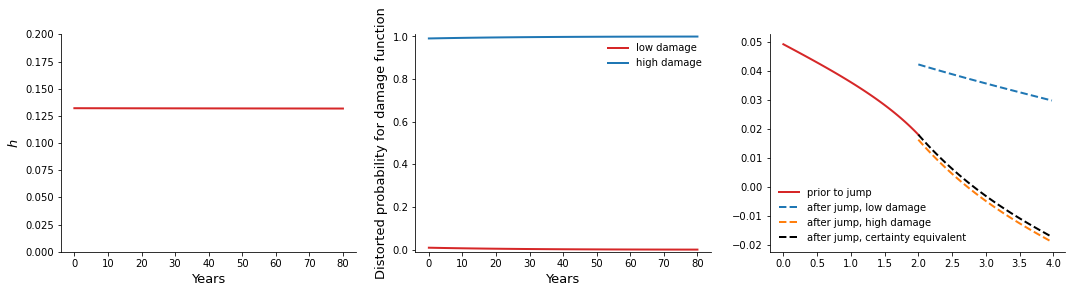

In [5]:
# # 1. damage neutrality
# make_plots(1./400, 1000., 1000., '../plots/decomposition/damage_neutral.pdf')
# 1. x1
make_plots(1./400, 1./400, 1000., '../plots/decomposition/damage_x1.pdf')
# # 2. x5
# make_plots(1./400., 1./400.*5, 1000., '../plots/decomposition/damage_x5.pdf')
# # 3. x10
# make_plots(1./400, 1./400.*10, 1000., '../plots/decomposition/damage_x10.pdf')
# # 4. x20
# make_plots(1./400, 1./400.*20, 1000., '../plots/decomposition/damage_x20.pdf')
# # 5. x40
# make_plots(1./400, 1./400.*40, 1000., '../plots/decomposition/damage_x40.pdf')

In [ ]:
ξ_1m, ξ_2m, ξ_a = (1./400., 1./400.*20, 1000.)

η = .032
δ = .01

θ = pd.read_csv('../data/model144.csv', header=None).to_numpy()[:, 0]/1000.
πc_o = np.ones_like(θ)/len(θ)
σ_y = 1.2*1.86/1000

y_bar = 2.
γ_1 = 1.7675/10000
γ_2 = .0022*2
γ_2p = np.array([0, .0197*2])
πd_o = np.array([.5, .5])

y_step = .02
y_grid_long = np.arange(0., 4., y_step)
y_grid_short = np.arange(0., 2.+y_step, y_step)
n_bar = int(2./y_step) + 1

# Prepare ϕ_i
ϕ_list = []
for γ_2p_i in γ_2p:
    model_paras = (η, δ, θ, πc_o, σ_y, ξ_1m, ξ_a, γ_1, γ_2, γ_2p_i, y_bar) 
    model_res = ode_y(y_grid_long, model_paras, v0=None, ϵ=.5,
                       tol=1e-8, max_iter=10_000, print_all=False)
    ϕ_list.append(model_res['v0'])

ϕ_list_short = []
for ϕ_i in ϕ_list:
    temp = ϕ_i[:n_bar]
    ϕ_list_short.append(temp)
ϕ_i = np.array(ϕ_list_short)

# Compute ϕ
ς = .15
model_paras = (η, δ, θ, πc_o, σ_y, ξ_1m, ξ_2m, ξ_a, ς, γ_1, γ_2, y_bar, ϕ_i, πd_o)
model_res = ode_y_jump_approach_one_boundary(y_grid_short, model_paras, v0=ϕ_i[1],
                                  ϵ=.5, tol=1e-8, max_iter=10_000, print_all=False)

h = 1./ξ_1m * (-model_res['v0_dy'] + (1-η)*model_res['d_Λ']) * model_res['e_tilde'] * σ_y

# Simulate e_tilde
et_tilde, yt, ht, gt = simulation(y_grid_short, model_res['e_tilde'], h, model_res['g'], θ=1.86/1000., y_start=.5394, T=80)

# Check if value matching
y_after = y_grid_long[n_bar-1:]
ϕ_after_list = [temp[n_bar-1:] for temp in ϕ_list]
g0 = model_res['g'][0, -1]
g1 = model_res['g'][1, -1]
g_mean = g0*.5 + g1*.5
ϕ_after_mean = -ξ_2m*np.log(πd_o[0]*np.exp(-1./ξ_2m*ϕ_after_list[0]) + 
                            πd_o[1]*np.exp(-1./ξ_2m*ϕ_after_list[1]))
ϕ_after_low = ϕ_after_list[0]
ϕ_after_high = ϕ_after_list[1]

In [ ]:
plt.plot(model_res['v0'])

In [ ]:
y_after

In [ ]:
y_grid_short

In [ ]:
plt.plot(y_after, ϕ_after_mean)
plt.plot(y_grid_short, model_res['v0'])

In [ ]:
-ξ_2m*np.log(np.sum(πd_o*np.exp(-1./ξ_2m*ϕ_i[:, -1])))

In [ ]:
y_grid_long[n_bar:]